In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

In [2]:
save_plots = True; save_plots = False #whether to save the resulting plots
show_box_plots = True#; show_box_plots = False

pd.options.mode.chained_assignment = None #turns off warnings for data replacements

#Load the weather data and merge them into our two DataFrames.'''
stopwatch = TimeTracker.TimeTracker()
WORKING_DIR = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather'
os.chdir(WORKING_DIR + r'\data')
print('Loading weather events')
weather_events = pd.read_csv('daily_weather.csv')
print(weather_events.columns)
weather_events.drop('index', axis=1, inplace=True)
inputVars = pd.Series(weather_events.columns[2:])

print('Loading flight data')
departing_flights = pd.read_csv('departing_flights.csv')
arriving_flights = pd.read_csv('arriving_flights.csv')

Loading weather events
Index(['Airport', 'Date', 'Cold', 'Fog', 'Hail', 'Wind', 'Rain', 'Sleet',
       'Snow', 'index'],
      dtype='object')
Loading flight data


In [3]:
# Merge the DataFrames.
departure_events = departing_flights.merge(
    weather_events, how='left', left_on=['ORIGIN','DepartureDate'],
    right_on=['Airport','Date'], validate='one_to_many')
arrival_events = arriving_flights.merge(
    weather_events, how='left', left_on=['DEST','ArrivalDate'],
    right_on=['Airport','Date'], validate='one_to_many')

In [4]:
# Drop redundant columns.
print(departure_events.columns)
print(arrival_events.columns)
departure_events.drop(['Airport','Date'], axis=1, inplace=True)
arrival_events.drop(['Airport','Date'], axis=1, inplace=True)

# Clean up the column names.
column_renames = {'ARR_DEL15':'ArrivDelay',
                  'DEP_DEL15':'DepartDelay'}
departure_events.rename(columns=column_renames, inplace=True)
arrival_events.rename(columns=column_renames, inplace=True)

# NaN's mean no weather events on that day. Fill them in with 0's.
for column in inputVars:
    departure_events[column].fillna(0, inplace=True)
    arrival_events[column].fillna(0, inplace=True)
    
# Earlier DFs are no longer needed.
del(weather_events, departing_flights, arriving_flights, column)

Index(['ORIGIN', 'DepartureDate', 'ARR_DEL15', 'DEP_DEL15', 'Flights',
       'WeatherCancelled', 'WeatherDelayed', 'Airport', 'Date', 'Cold', 'Fog',
       'Hail', 'Wind', 'Rain', 'Sleet', 'Snow'],
      dtype='object')
Index(['DEST', 'ArrivalDate', 'ARR_DEL15', 'DEP_DEL15', 'Flights',
       'WeatherCancelled', 'WeatherDelayed', 'Airport', 'Date', 'Cold', 'Fog',
       'Hail', 'Wind', 'Rain', 'Sleet', 'Snow'],
      dtype='object')


In [5]:
'''Exploratory data analysis'''
FRAC_CANCELLED = 'FracCancelled'
FRAC_DELAYED = 'FracDelayed'
departure_events[FRAC_CANCELLED] = departure_events.WeatherCancelled/departure_events.Flights
arrival_events[FRAC_CANCELLED] = arrival_events.WeatherCancelled/arrival_events.Flights
departure_events[FRAC_DELAYED] = departure_events.WeatherDelayed/departure_events.Flights
arrival_events[FRAC_DELAYED] = arrival_events.WeatherDelayed/arrival_events.Flights
frac_cancelled = departure_events['FracCancelled']
frac_delayed = departure_events['FracDelayed']

In [6]:
'''Monthly summaries of departure cancellations and delays.'''
def get_monthly_summaries(df):
    monthly_summaries = df[['ORIGIN','DepartureDate','FracCancelled','FracDelayed']]
    monthly_summaries['Month'] = monthly_summaries.DepartureDate.str[5:7].astype(int)
    monthly_summaries = monthly_summaries.groupby(['ORIGIN','Month']).mean().reset_index()
    return monthly_summaries

In [7]:
monthly_summaries = get_monthly_summaries(departure_events)
print('Max fraction of flights affected: %.4f' % monthly_summaries.iloc[:,2:].max().max())
busiest_airports = pd.read_csv('busiest_US_airports2018.csv', index_col='Rank')
busiest_airports.rename({'Airport': 'Code'}, axis=1, inplace=True)
#Naming them by hand to allow for name customization.
busiest_airports['Airport'] =  busiest_airports.Code.map(
    {'ATL':'Atlanta', 'BOS':'Boston', 'CLT':'Charlotte', 'DEN':'Denver', 'DFW':'Dallas/Fort Worth',
     'EWR':'Newark', 'IAH':'Houston Intercontinental', 'JFK':'New York JFK', 'LAS':'Las Vegas',
     'LAX':'Los Angeles', 'MIA':'Miami', 'MCO':'Orlando', 'ORD':"Chicago O'Hare",
     'SEA':'Seattle', 'SFO':'San Francisco', 'PHX':'Phoenix', 'MSP':'Minneapolis–Saint Paul',
     'DTW':'Detroit', 'PHL':'Philadelphia', 'LGA':'New York LaGuardia', 'FLL':'Fort Lauderdale',
     'BWI':'Baltimore/Washington', 'SLC':'Salt Lake City', 'SAN':'San Diego'})
busiest_airports.sort_values(by='Airport', inplace=True)

Max fraction of flights affected: 0.0610


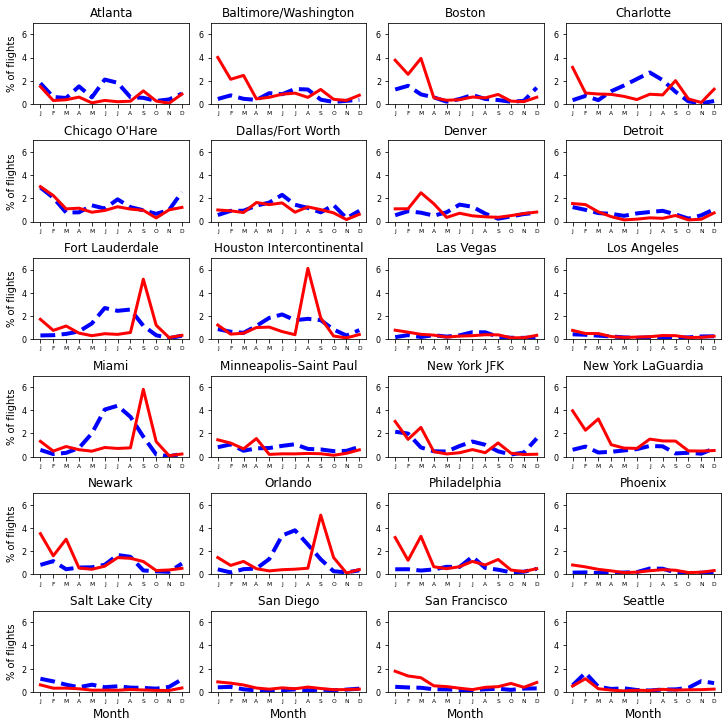

In [8]:
'''Line plots for all the major airports.
Solid red lines = cancellations; broken blue lines = delays.'''
def summaryplots(df, version=''):
    h, w = 6, 4
    months = list('JFMAMJJASOND')
    x = np.arange(1, len(months)+1)
    fig, axs = plt.subplots(nrows=h, ncols=w, figsize=(10, 10), constrained_layout=True)
    for i in range(h):
        for j in range(w):
            ax = axs[i,j]
            airport_index = df[df.ORIGIN == busiest_airports.iloc[w*i + j].loc['Code']].index.to_numpy()
            ax.plot(x, 100*df.FracDelayed[airport_index], color='b', lw=4, ls='--')
            ax.plot(x, 100*df.FracCancelled[airport_index], color='r', lw=3)
            ax.set_title(busiest_airports.Airport.iloc[w*i + j], fontsize=12)
            ax.set_xticks(x)
            ax.set_xticklabels(months, fontsize=6)
            ax.set_ylim([0,7])
            ax.tick_params(axis='y', which='major', labelsize=8)
            if i==h-1:
                ax.set_xlabel("Month", fontsize=12)
            if j==0:
                ax.set_ylabel("% of flights", fontsize=10)
    #plt.tight_layout()
    os.chdir(WORKING_DIR + r'\figures')
    if save_plots:
        plt.savefig('MonthlySummariesByAirport' + str(version) + '.png')
    plt.show()

summaryplots(monthly_summaries)

Houston and the Florida airports show spikes in cancellations. Houston's came in
Aug. 2017 from Hurricane Harvey, and the Florida airports' came in Sept. 2017
from Hurricane Irma. Let's take a closer look at these data.

In [9]:
HARVEY = np.arange(13473, 13480) #no wind codes
IRMA_FLL = np.arange(12056, 12062) #12057 has wind 1, rain 3
IRMA_MCO = np.arange(20637, 20642) #20638 has wind 1, rain 3
IRMA_MIA = np.arange(22066, 22075) #22068 has wind 1, rain 2
DORIAN = np.arange(21328, 21333) #no wind codes
for hurricane in [HARVEY, IRMA_FLL, IRMA_MCO, IRMA_MIA, DORIAN]:
    print(departure_events.iloc[hurricane]\
          .loc[:,['ORIGIN','DepartureDate','Wind','Rain','FracCancelled']])

      ORIGIN DepartureDate  Wind  Rain  FracCancelled
13473    IAH    2017-08-26   0.0   3.0       0.613793
13474    IAH    2017-08-27   0.0   3.0       0.962963
13475    IAH    2017-08-28   0.0   3.0       0.988889
13476    IAH    2017-08-29   0.0   3.0       1.000000
13477    IAH    2017-08-30   0.0   1.0       0.991549
13478    IAH    2017-08-31   0.0   0.0       0.866667
13479    IAH    2017-09-01   0.0   0.0       0.486264
      ORIGIN DepartureDate  Wind  Rain  FracCancelled
12056    FLL    2017-09-08   0.0   1.0       0.304147
12057    FLL    2017-09-09   1.0   3.0       0.985981
12058    FLL    2017-09-10   0.0   0.0       0.986547
12059    FLL    2017-09-11   0.0   0.0       0.986726
12060    FLL    2017-09-12   0.0   0.0       0.717073
12061    FLL    2017-09-13   0.0   1.0       0.239234
      ORIGIN DepartureDate  Wind  Rain  FracCancelled
20637    MCO    2017-09-09   0.0   1.0       0.415625
20638    MCO    2017-09-10   1.0   3.0       0.993884
20639    MCO    2017-09-11  

Harvey in particular dumped an unprecedented amount of rain onto Greater Houston.
Leaving this data in would suggest to the training model later that heavy rain alone
is enough to cause a significant amount of cancellations or even shut down the airport,
as it did then. Note the lack of Wind codes; a hurricane's strong winds are generally
near the eye, but rain can spread out for hundreds of miles.

Dropping all these hurricane data is sensible for the ones where wind=0. For the
other data points, let's see how many data points have Wind>0 and Rain>1.

In [10]:
rain_wind_summary = lambda df, column: df.groupby(['Rain','Wind']).mean()[column].unstack(level='Rain')

rain_wind_cancelled = rain_wind_summary(departure_events, 'FracCancelled')
rain_wind_delayed = rain_wind_summary(departure_events, 'FracDelayed')
print('Cancellations vs. rain and wind:\n' + str(rain_wind_cancelled))
print('\nDelays vs. rain and wind:\n' + str(rain_wind_delayed))

Cancellations vs. rain and wind:
Rain       0.0       1.0       2.0       3.0
Wind                                        
0.0   0.005795  0.008494  0.014915  0.024292
1.0   0.045907  0.092150  0.128830  0.118011

Delays vs. rain and wind:
Rain       0.0       1.0       2.0       3.0
Wind                                        
0.0   0.003120  0.008536  0.017819  0.047117
1.0   0.017814  0.028560  0.036527  0.094204


Recall that our correlation between wind and rain is only 0.047. It seems more likely
that high winds and heavy rains independently increase the likelihood of cancellations
and delays. Our best bet is to remove the hurricane events and reanalyze.

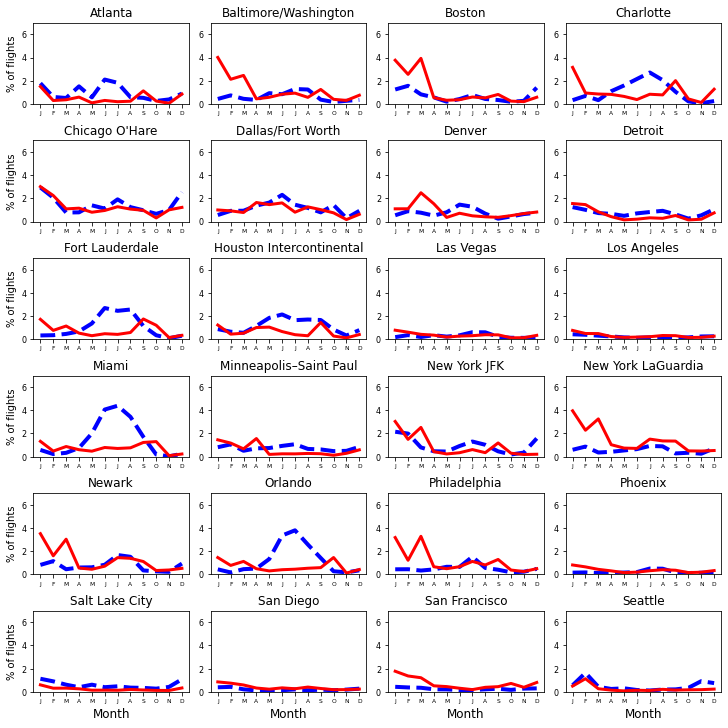

In [11]:
HURRICANE_INDECES = np.r_[HARVEY, IRMA_FLL, IRMA_MCO, IRMA_MIA, DORIAN]
departure_events.drop(HURRICANE_INDECES, axis=0, inplace=True)
frac_cancelled.drop(HURRICANE_INDECES, inplace=True)
frac_delayed.drop(HURRICANE_INDECES, inplace=True)
monthly_summaries1 = get_monthly_summaries(departure_events)
summaryplots(monthly_summaries1, version=1)

The cancellation spikes are gone.

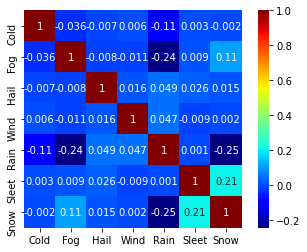

In [12]:
#Weather events correlation matrix
plt.figure()
weather_events_corr = pd.read_csv(
    'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data\weather_code_corr.csv')
weather_events_corr.set_index(weather_events_corr.columns[0], inplace=True)
weather_events_corr.index.rename('Index', inplace=True)
corr_ax = sns.heatmap(weather_events_corr, square=True, annot=True, cmap=plt.get_cmap('jet'))
corr_ax.set_ylabel('')
if save_plots:
    plt.savefig('CorrMatrixPlot.png')
plt.show()

In [13]:
#Max absolute difference.
maxAbsDiff = lambda A, B, axis=None: np.max(np.abs(A-B), axis=axis)

In [14]:
X_dep = departure_events.loc[:, inputVars]
X_arr = arrival_events.loc[:, inputVars]
print('Deviation from X_dep and array of ints:', maxAbsDiff(X_dep, X_dep.astype(int)) )
print('\nDeviation from X_arr and array of ints:', maxAbsDiff(X_arr, X_arr.astype(int)) )
X_dep = X_dep.astype(int)
X_arr = X_arr.astype(int)

print("Deviation between X_dep and X_arr's correlation matrices:")
print(maxAbsDiff(X_dep.corr(), X_arr.corr()))

Deviation from X_dep and array of ints: Cold     0.0
Fog      0.0
Hail     0.0
Wind     0.0
Rain     0.0
Sleet    0.0
Snow     0.0
dtype: float64

Deviation from X_arr and array of ints: Cold     0.0
Fog      0.0
Hail     0.0
Wind     0.0
Rain     0.0
Sleet    0.0
Snow     0.0
dtype: float64
Deviation between X_dep and X_arr's correlation matrices:
Cold     0.009808
Fog      0.000846
Hail     0.000291
Wind     0.009808
Rain     0.002287
Sleet    0.000149
Snow     0.000563
dtype: float64


These deviations are very low, which is to be expected given that X_dep and
X_arr have very similar daily data. We will proceed only with departure events.

In [15]:
Avg = pd.DataFrame(map(list, zip(inputVars.values, np.average(
    X_dep, axis=0, weights=departure_events.Flights))), columns=['Code', 'WtAvg'])
Avg = Avg.set_index('Code')['WtAvg']
print('\nWeighted averages: ' + str(Avg) + '\n')


Weighted averages: Code
Cold     0.005150
Fog      0.172958
Hail     0.001543
Wind     0.005798
Rain     0.500502
Sleet    0.002484
Snow     0.071907
Name: WtAvg, dtype: float64



Now let's do some plots, per code, categorized by code value. To make things
simpler we will not weight these values for now. There are a ton of outliers; we
will do the plots both with and without them.

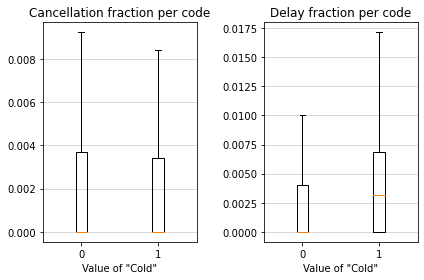

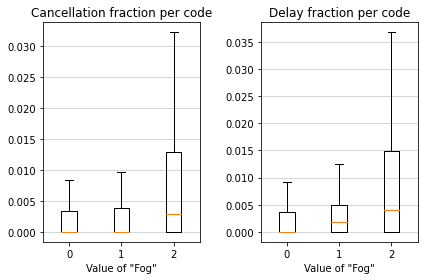

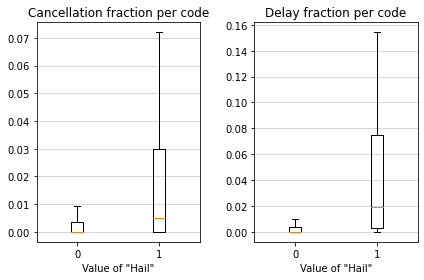

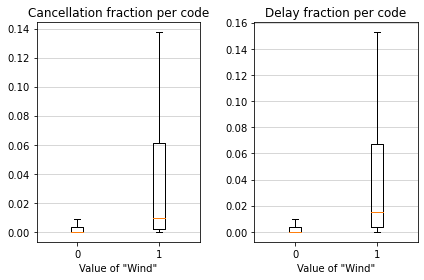

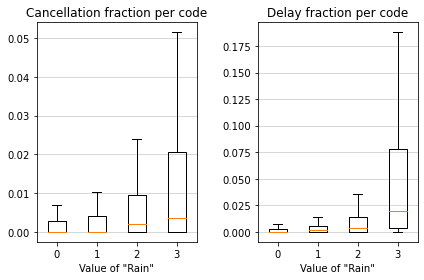

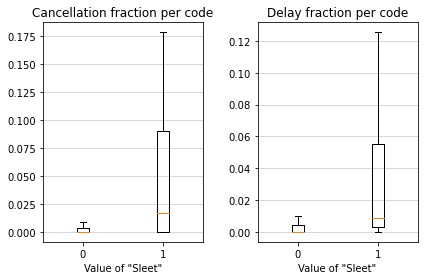

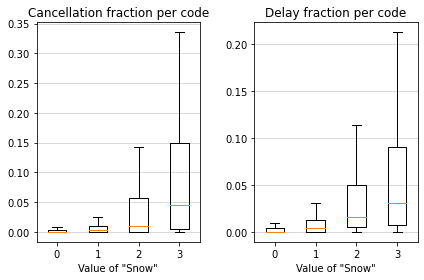

In [16]:
if show_box_plots:
    for showfliers in [False]: #Outliers. Including outliers gives messy plots.
        for weatherCode in inputVars:
            unique_codes = np.sort(X_dep[weatherCode].unique()) #A Series of value counts indexed by code #
            cancelled_per_code = [frac_cancelled[X_dep[weatherCode]==j] for j in unique_codes]
            delayed_per_code = [frac_delayed[X_dep[weatherCode]==j] for j in unique_codes]
        
            fig, axs = plt.subplots(1,2)
            axs[0].boxplot(cancelled_per_code, showfliers=showfliers)
            axs[0].set_title('Cancellation fraction per code')
            axs[1].boxplot(delayed_per_code, showfliers=showfliers)
            axs[1].set_title('Delay fraction per code')
            for j in [0,1]:
                axs[j].set_xticklabels(unique_codes)
                axs[j].set_xlabel('Value of "' + weatherCode + '"')
                axs[j].grid(axis='y',zorder=-2, linewidth=0.5)
            plt.tight_layout()
            if save_plots and not showfliers:
                plt.savefig('BoxPlot' + weatherCode + '.png')
            plt.show()

The medians of some of these features clearly are affected by the feature value;
however, none of them seem to add up to much more than about 0.20, meaning that
we should not expect that these weather events will have an overwhelming affect
on delays and cancellations. Still, there do seem to be trends that emerge.

In [17]:
# Get rid of some variables that are no longer needed.
del(Avg, FRAC_CANCELLED, FRAC_DELAYED, X_arr, X_dep,arrival_events,
    column_renames, corr_ax, frac_cancelled, frac_delayed, weather_events_corr,
    HARVEY, IRMA_FLL, IRMA_MCO, IRMA_MIA, DORIAN, HURRICANE_INDECES, hurricane)

Next, we would like to categorize the results according to region. This should be
a combination of similar geography and regions.
1) Florida gets its own region due to all the weather delays in the summer.
2) Denver is classified as "Midwest" because it resembles these' airports weather
    problems more than the rest of the Western airports.

In [18]:
region_map = {'Northeast':['BWI','PHL','EWR','JFK','LGA','BOS'],
              'West':['SLC','PHX','SAN','LAX','SFO','SEA','LAS'],
              'Midwest':['DTW','ORD','MSP','DEN'],
              'South':['ATL','CLT','IAH','DFW'],
              'Florida':['MCO','MIA','FLL']}

WINTER = 'Winter'; SPRING = 'Spring'; SUMMER = 'Summer'; FALL = 'Fall'
# We could get this down to the exact dates, but let's be consistent with the line charts.
season_map = {WINTER: [1,2,3], #Jan, Feb, Mar
              SPRING: [4,5,6], #Apr, May, Jun
              SUMMER: [7,8,9], #Jul, Aug, Sep
              FALL: [10,11,12]} #Oct, Nov, Dec

In [19]:
'''Maps a dictionary onto a column of a DataFrame.

df: The DataFrame to map onto.
inputCol: Name of the DataFrame's column.
dict_map: The mapping dictionary.'''
def mapDict(df, inputCol, dict_map):
    output = []
    for x in df[inputCol]:
        for key, items in dict_map.items():
            if x in items:
                output.append(key)
                break
        else:
            raise ValueError(x + ' ' + str(items) + ' not listed in your dictionary')
    return output

In [20]:
departure_events['Month'] = departure_events.DepartureDate.str[5:7].astype(int) #month no.
print('Calculating season')
departure_events['Season'] = pd.Series(mapDict(departure_events, 'Month', season_map))
print('Assigning regions')
departure_events['Region'] = mapDict(departure_events, 'ORIGIN', region_map)

airport_groups = departure_events.drop(
    ['ArrivDelay','DepartDelay','FracCancelled','FracDelayed','Month'], axis=1)\
    .groupby(['ORIGIN','Season']).sum().reset_index()

Calculating season
Assigning regions


In [21]:
if save_plots:
    os.chdir(WORKING_DIR + r'\data')
    departure_events.to_csv('departure_events.csv')
print('\nTotal runtime:', stopwatch.getElapsedTime())


Total runtime: --- 10.86 seconds ---
